## Analysis notebook for Thompson Sampling of GDH-CatIB strains

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
from matplotlib import cm, pyplot
import numpy
import pandas
import pathlib

import calibr8
import catibts
import pyrff

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%load_ext watermark
%watermark --iversions

arviz     : 0.11.4
ipywidgets: 7.6.5
numpy     : 1.21.5
pandas    : 1.4.1
retl      : 0.3.1
matplotlib: 3.5.1
scipy     : 1.7.3
calibr8   : 6.5.1
pyrff     : 2.0.1
pymc      : 4.0.0b2
catibts   : 0.1.0



In [4]:
fp_experiment = pathlib.Path(r"../data")
fp_experiment.exists()
runinfo_df = pandas.read_excel(f"{fp_experiment}/run_overview.xlsx", index_col=0)
runinfo_df

,run_id-VK,result_file-VK,run_id-HK,result_file-HK,run_id-Assay,result_file(s)-Assay,Anmerkungen
sround,,,,,,,
0,D15DTK,ReHa_CatIB_VK_2022-01-27_16-30-13.csv,D19YYZ,ReHa_CatIB_HK_2022-01-28_12-32-33.csv,D1X8DM,"2022-01-31_07-12_Fluorescence.xml, 2022-01-31_...",Hier hatte ich in der VK noch mit dem shutil-B...
1,D95YC6,ReHa_CatIB_VK_2022-03-03_19-34-37.csv,D9A1YM,ReHa_CatIB_HK_2022-03-04_14-10-23.csv,D9XCLX,"2022-03-07_09-34_Fluorescence.xml, 2022-03-08_...","Für die Vokultur gibt es mehrere Runs, die jew..."
2,DAFT9R,ReHa_CatIB_VK_2022-03-10_16-00-57.csv,DAMZ19,ReHa_CatIB_HK_2022-03-11_10-23-45.csv,DB984D,2022-03-14_05-41_Fluorescence.xml,Einige Wells der Vorkultur sind nicht richtig ...
3,DDA79K,ReHa_CatIB_VK_2022-03-24_15-26-08.csv,DDEBDB,ReHa_CatIB_HK_2022-03-25_09-54-09.csv,DE3MB4,2022-03-28_05-09_Fluorescence.xml,Ein Well zeigte schon in der VK Verhaltensauff...


All run IDs are ['D1X8DM' 'D9XCLX' 'DB984D' 'DE3MB4']


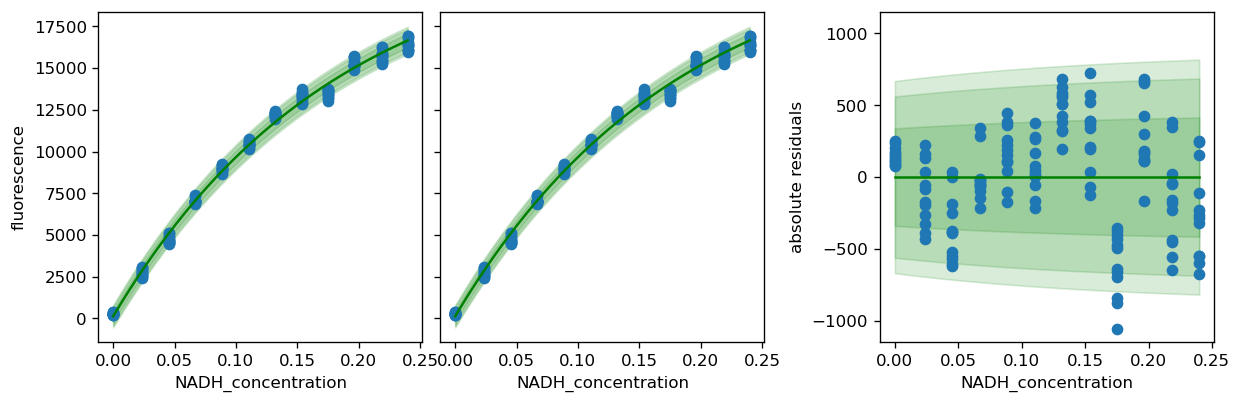

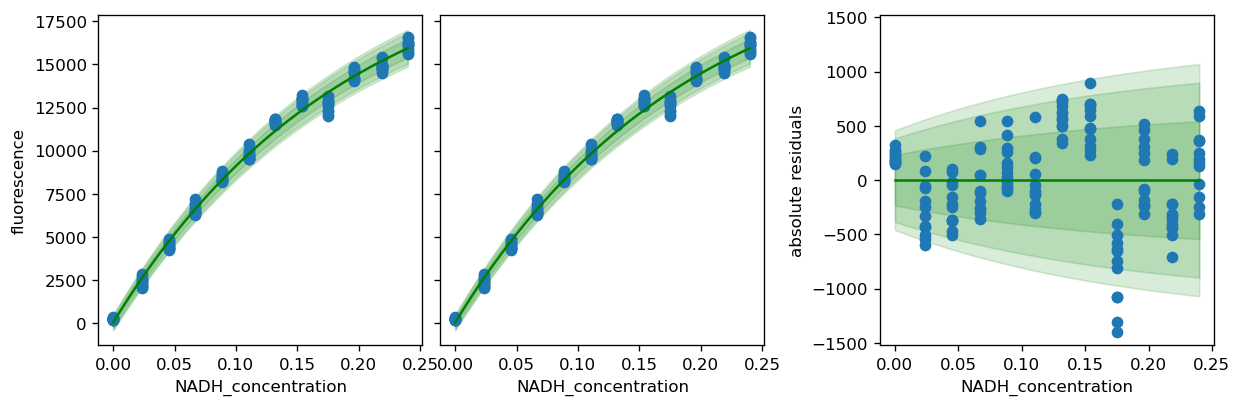

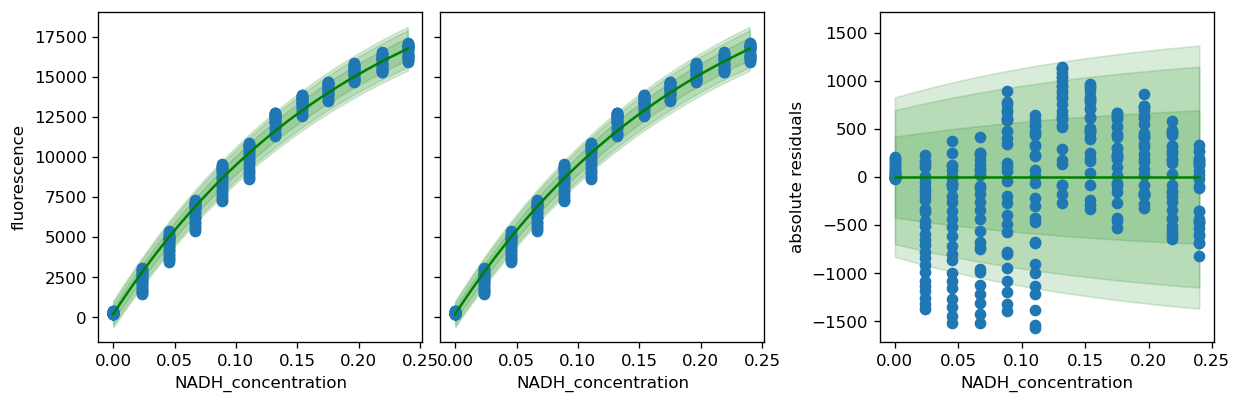

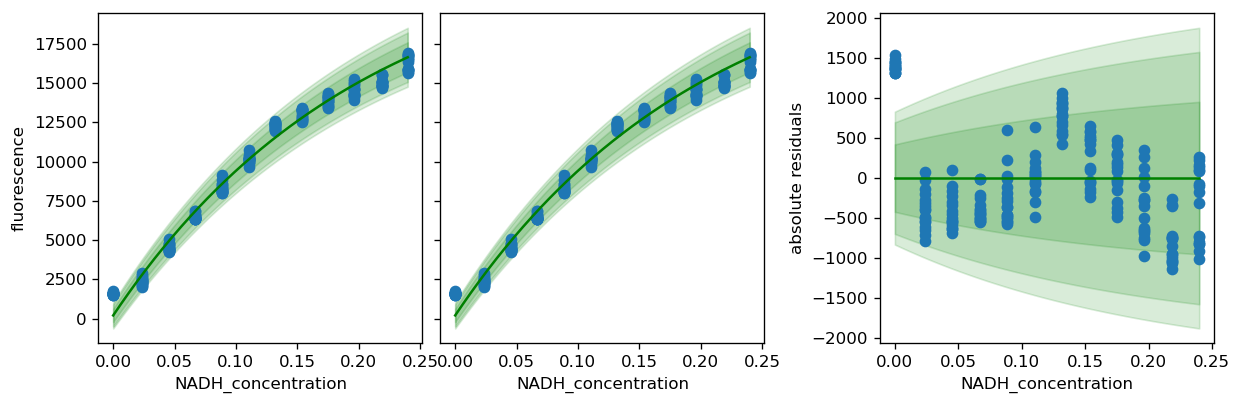

In [5]:
run_list = runinfo_df["run_id-Assay"].values
resultpaths = [rf"Results\{run}" for run in run_list]
print(f"All run IDs are {run_list}")
cmodels = [
    catibts.NADHFluorescenceModel.load(rf"{r_path}\{run}_cm_nadh.json") 
    for r_path, run in zip(resultpaths, run_list)
]
for cm_nadh in cmodels:
    fig, axs = calibr8.plot_model(cm_nadh)
    pyplot.show()


## Read the kinetics DataFrames

In [6]:
prev_runs = []
df_kinetics_list = []
for run in run_list:
    prev_runs.append(run)
    df_kinetics = catibts.concatenate_kinetics(
            run_list=prev_runs, 
            runinfo_df=runinfo_df,
            fp_experiment=fp_experiment,
            cut_cycle=146
    )
    df_kinetics_list.append(df_kinetics)

In [7]:
filenames = [
    "D1X8DM_catib-ts_round1.nc",
    "D9XCLX_catib-ts_Lognorm-hyperprior_round2.nc",
    "DB984D_catib-ts_Lognorm-hyperprior_round3.nc",
    "DE3MB4_catib-ts_round4.nc",
]
# {RUN_ID}_catib-ts_Lognorm-hyperprior_round3.nc]
idata_list = [
    arviz.from_netcdf(fr"{resultpath}\{filename}")
    for resultpath, filename in zip(resultpaths, filenames)
]


In [8]:
posteriors = [
    idata.posterior.stack(sample=("chain", "draw"))
    for idata in idata_list
]
posteriors[0]

<xarray.Dataset>
Dimensions:                (kinetic_id: 48, sample: 2000, strain: 64, run: 1,
                            column_id: 8, assay_cycle: 146)
Coordinates:
  * kinetic_id             (kinetic_id) object 'B02_D1X8DM' ... 'G09_D1X8DM'
  * strain                 (strain) object 'KK166' 'KK167' ... 'RoSa98' 'RoSa99'
  * run                    (run) object 'D1X8DM'
  * column_id              (column_id) int32 2 3 4 5 6 7 8 9
  * assay_cycle            (assay_cycle) int32 0 1 2 3 4 ... 141 142 143 144 145
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    cf_nadh_assay          (kinetic_id, sample) float64 0.8704 0.9093 ... 0.9944
    k_sd                   (sample) float64 0.1805 0.168 0.232 ... 0.1743 0.1714
    k_mean                 (sample) float64 0.1747 0.1621 ... 0.1732 0.1702
    k                      (strain, sample) float64 -0.2122 0.1468 ... 0.2863
    batch_effect           (run, sample) float64 0.9691 1.124 ... 1.067 1.085
    t_offset               (sample) float64 0.2826 0.2848 ... 0.2814 0.2813
    t_plate_to_reader      (sample) float64 0.4731 0.4711 ... 0.5049 0.4752
    S0                     (sample) float64 0.2018 0.197 0.2 ... 0.201 0.1979
    k_batch                (kinetic_id, sample) float64 0.00195 ... 0.1272
    k_assay                (kinetic_id, sample) float64 3.394e-05 ... 0.00253
    t_column               (column_id, sample) float64 0.4731 0.4711 ... 2.444
    product_concentration  (kinetic_id, assay_cycle, sample) float64 5.206e-0...
Attributes:
    created_at:                 2022-03-03T17:14:17.205300
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              1875.2539961338043
    tuning_steps:               1000

In [9]:
idata_prior = arviz.from_netcdf(r"Results\DE3MB4\DE3MB4_prior_predictive.nc")
prior = idata_prior.prior.stack(sample=("chain", "draw"))
prior

<xarray.Dataset>
Dimensions:                (kinetic_id: 184, sample: 500, assay_cycle: 146,
                            strain: 64, run: 4, column_id: 8)
Coordinates:
  * kinetic_id             (kinetic_id) object 'B02_D1X8DM' ... 'G09_DE3MB4'
  * assay_cycle            (assay_cycle) int32 0 1 2 3 4 ... 141 142 143 144 145
  * strain                 (strain) object 'KK166' 'KK167' ... 'RoSa98' 'RoSa99'
  * run                    (run) object 'D1X8DM' 'D9XCLX' 'DB984D' 'DE3MB4'
  * column_id              (column_id) int32 2 3 4 5 6 7 8 9
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  - draw                   (sample) int64 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    k_batch                (kinetic_id, sample) float64 0.1566 ... 0.008404
    t_plate_to_reader      (sample) float64 0.4655 0.4964 ... 0.4892 0.5107
    t_offset               (sample) float64 0.2801 0.2806 ... 0.2804 0.2831
    k_sd                   (sample) float64 0.003336 0.4642 ... 0.09618 0.05155
    product_concentration  (kinetic_id, assay_cycle, sample) float64 0.000520...
    k_mean                 (sample) float64 0.142 0.09286 ... 0.09231 0.008728
    k                      (strain, sample) float64 0.1425 0.131 ... 0.008665
    S0                     (sample) float64 0.2151 0.237 ... 0.2218 0.1952
    k_assay                (kinetic_id, sample) float64 0.00322 ... 0.0001609
    batch_effect           (run, sample) float64 1.102 1.066 ... 1.04 1.001
    cf_nadh_assay          (kinetic_id, sample) float64 1.028 0.9216 ... 0.957
    t_column               (column_id, sample) float64 0.4655 0.4964 ... 2.492
Attributes:
    created_at:                 2023-09-17T16:14:17.376398
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2

In [10]:
prior_probs = pyrff.sampling_probabilities(
    prior.k.values,
    correlated=True
)
posterior_probs = [
    pyrff.sampling_probabilities(
        posterior.k.values,
        correlated=True
    )
    for posterior in posteriors
]

In [11]:
ts_draws = {
    "r0": [1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
            1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
            1, 1, 1, 1],
    "r1": [0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 2, 1, 0, 1, 0, 3, 1,
           1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
           0, 0, 0, 0, 0, 0, 1, 13, 0, 6,
           8, 0, 5, 0],
    "r2": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
           0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 36, 0, 0,
           0, 0, 8, 0],
}


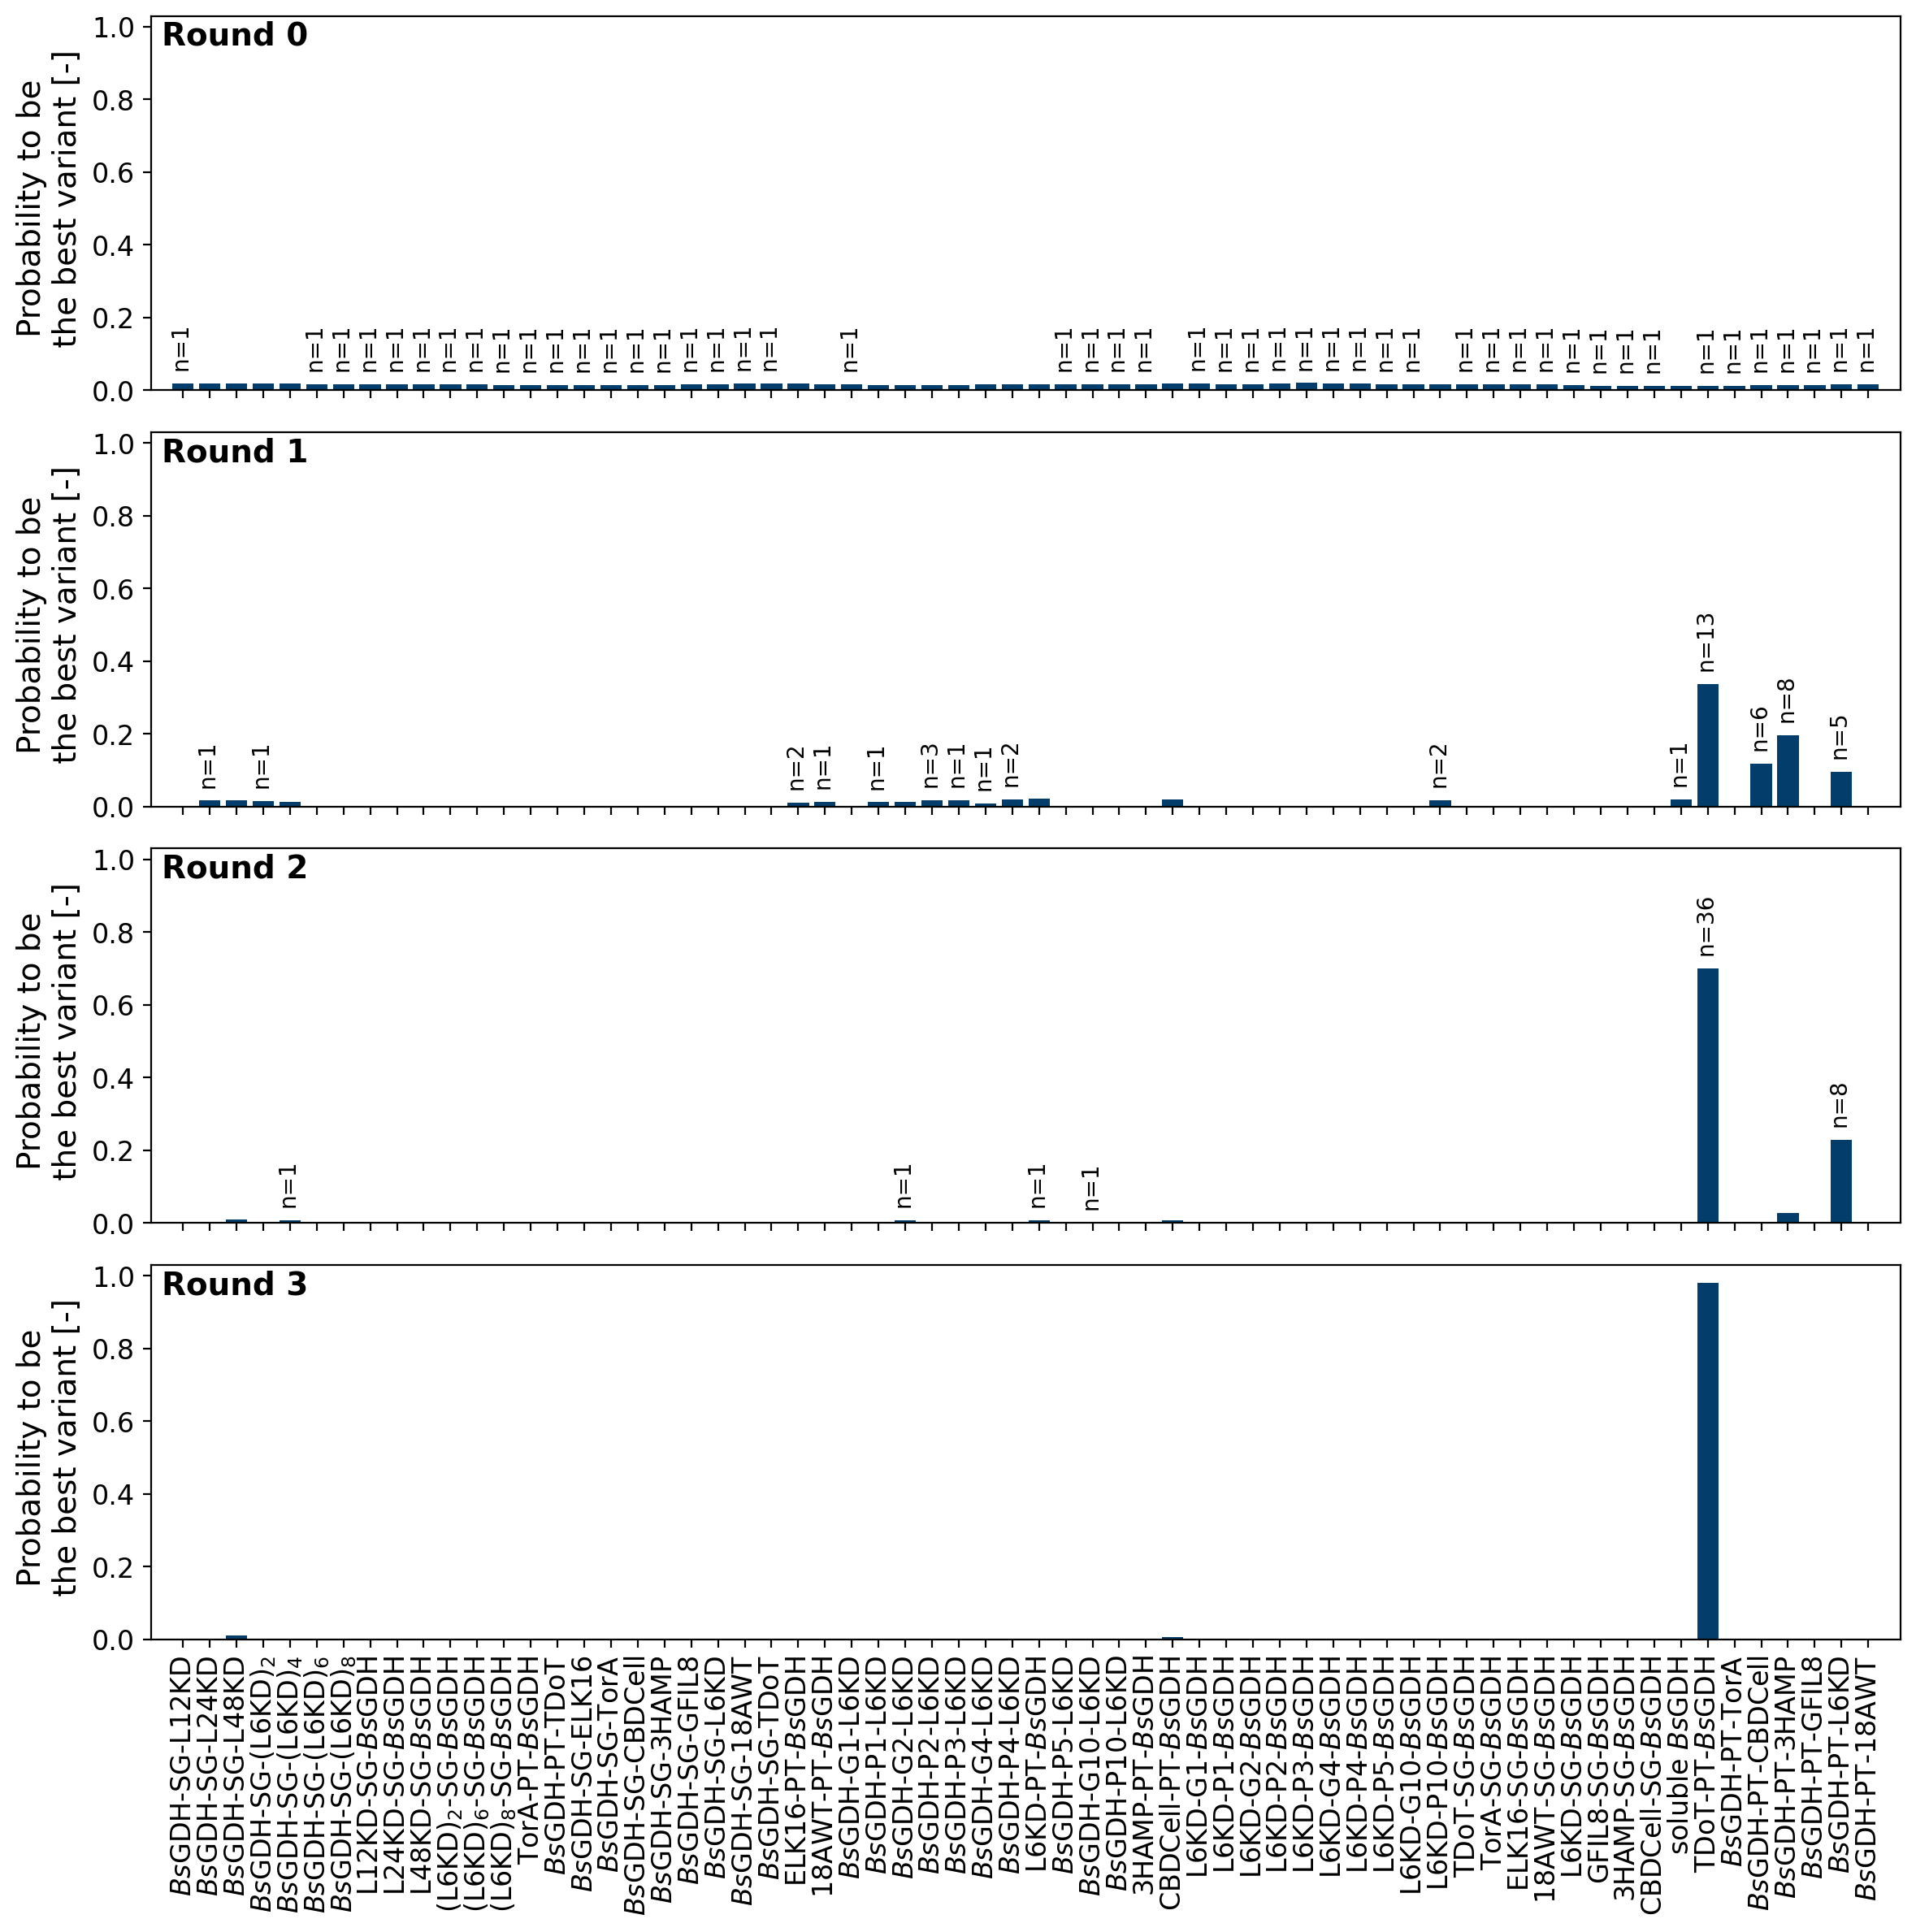

In [21]:
strain_dict = catibts.VARIANT_MAPPER

fig, axs = pyplot.subplots(figsize=(12,12), nrows=4, dpi=200, sharex=True, sharey=True)
for i, ax in enumerate(axs):
    if i == 0:
        probs = prior_probs
        strains = prior.strain.values
    else:
        probs = posterior_probs[i-1]
        strains = posteriors[i-1].strain.values
    ax.bar(x=numpy.arange(len(probs)), height=probs, color="#023D6B")
    ax.set_xlim(-1.2, 64.2)
    #ax.set_ylim(0, 0.5)
    ax.set_xticks(numpy.arange(len(probs)), labels=[strain_dict[strain] for strain in strains], rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylabel("Probability to be \n the best variant [-]", size=14)
    if i<3:
        for j, draw in enumerate(ts_draws[f"r{i}"]):
            if draw > 0:
                ax.annotate(text=f"n={draw}", xy=(j-0.5, probs[j] + 0.05), rotation=90)
    ax.annotate(f"Round {i}", xy=(-0.8, 0.95), fontweight="bold", size=14)
pyplot.tight_layout()
pyplot.savefig(r"TS_prob_all_rounds.pdf", dpi=200)
pyplot.show()

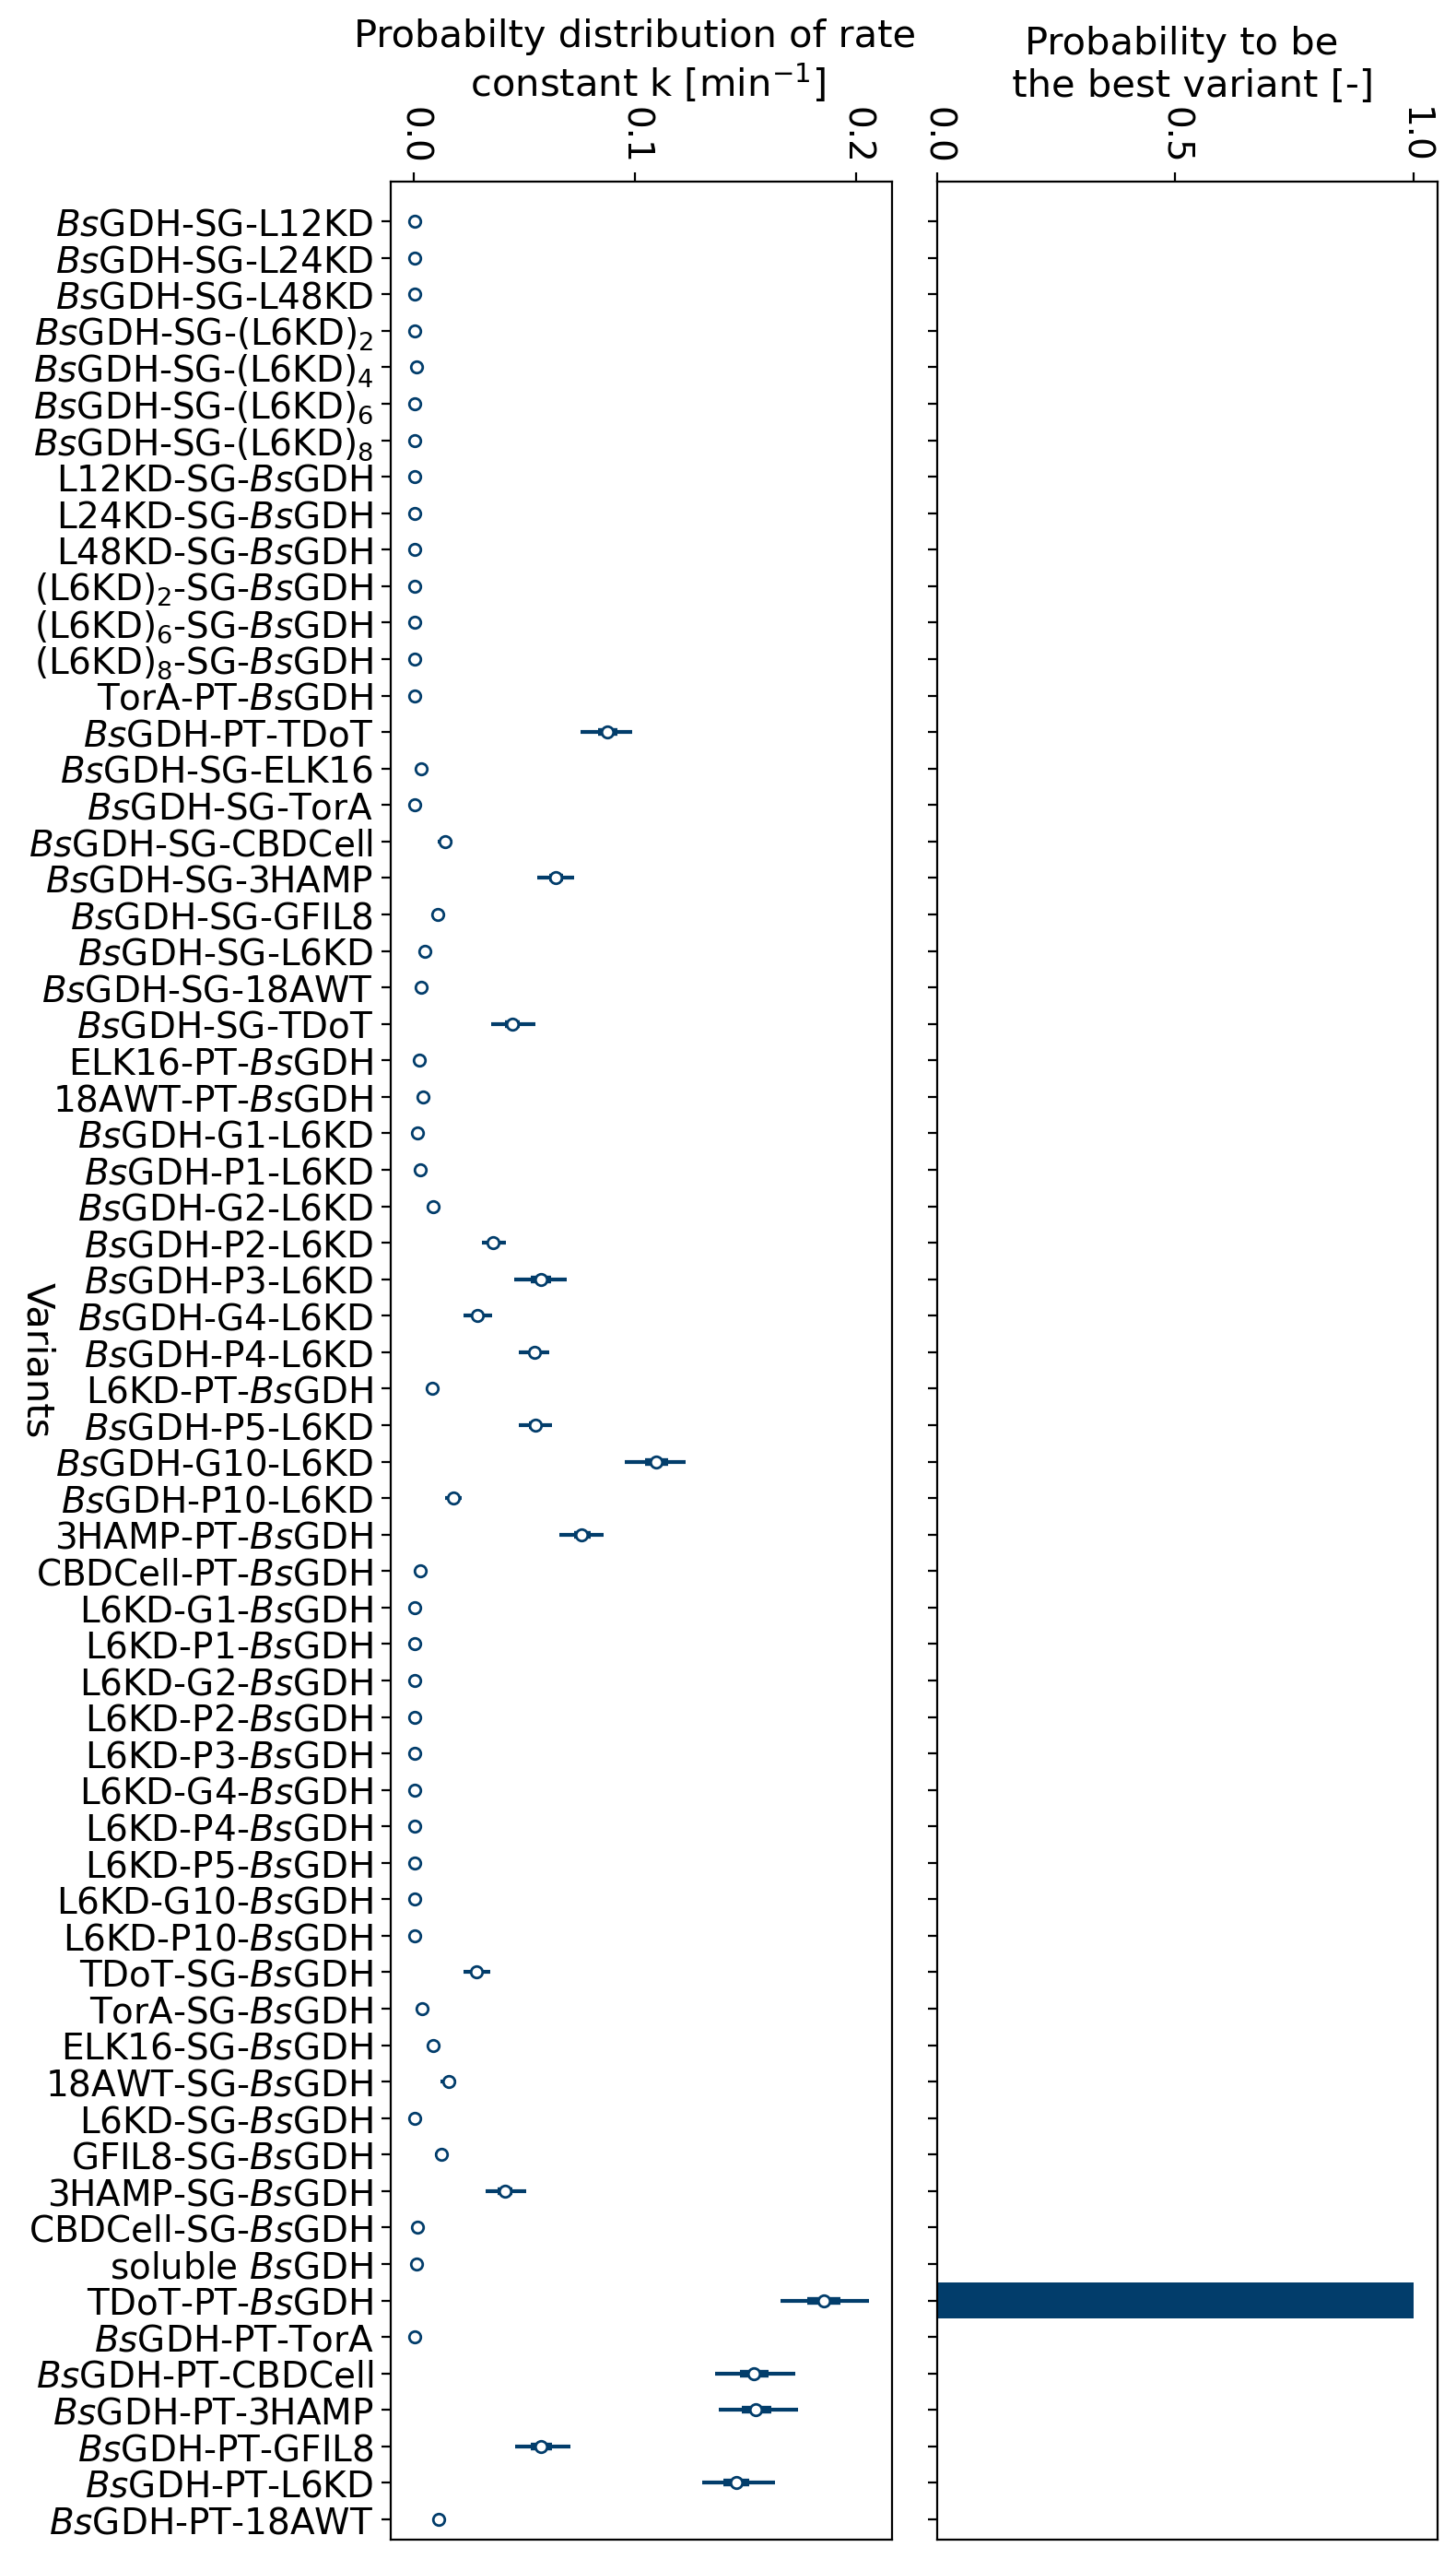

In [22]:
strain_dict = catibts.VARIANT_MAPPER

fig, axs = pyplot.subplots(figsize=(8,14), dpi=200, ncols=2, sharey=True)

ax = axs[0]
arviz.plot_forest(idata_list[-1], var_names=["k"], combined=True, ax=ax, colors=["#023D6B"])
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.set_xlabel("Probabilty distribution of rate \n constant k [min$^{-1}$]", size=15)
probs = posterior_probs[-1]
strains = posteriors[-1].strain.values
ax.set_yticklabels([strain_dict[strain] for strain in strains[::-1]])
ax.tick_params(axis='y', which='major', left=True, labelsize=14, color="k")
ax.tick_params(axis='x', which='major', labelsize=14, color="k", rotation=270)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylabel("Variants", size=15,  rotation=270)
ax.set_title("")

ax = axs[1]
ax.barh(y=axs[0].get_yticks(), width=probs[::-1], color="#023D6B")
ax.set_yticklabels([strain_dict[strain] for strain in strains[::-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14, color="k", rotation=270)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xlabel("Probability to be \n the best variant [-]", size=15)


pyplot.tight_layout()
pyplot.savefig(r"CatIB_kprobs+TSprob_round4.pdf", dpi=200)